In [73]:
import os  # Import module os để làm việc với hệ thống tệp và thư mục
import sys  # Import module sys để làm việc với biến và hàm của trình thông dịch Python
from tempfile import NamedTemporaryFile  # Import lớp NamedTemporaryFile từ module tempfile để tạo và làm việc với các tệp tạm thời
from zipfile import ZipFile  # Import lớp ZipFile từ module zipfile để thao tác với các tập tin nén ZIP
import tarfile  # Import module tarfile để thao tác với các tệp nén tar
import shutil  # Import module shutil để thực hiện các thao tác sao chép và di chuyển tệp


In [105]:
import requests  # Import module requests để thực hiện các yêu cầu HTTP
from urllib.parse import unquote  # Import hàm unquote từ module urllib.parse để giải mã URL
from tqdm import tqdm  # Import lớp tqdm từ module tqdm để hiển thị thanh tiến trình khi tải xuống

# Chuỗi URL đã mã hóa
encoded_url = 'https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F18%2F2157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240510%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240510T171529Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D348640283931f9c4dd02ba0bb5fd66196965d46418636da031b90b545926d07ce5879ed7be696c922ebb5a2b569a62d675549dff761f099a3e2ab79214260854c17c0f650418c8f00d42df510661af656cfd7f70852ee2c1f562763f38d1fa28686f310de50f43f9b123858b7928321fd6ed6185131e98f1949bf312e15b2c4af43abaf4c6deee5b11514e3e1d827d689e83ec88690ad80c61284691561f284f92a160cacc1fabe61159f873033aff1eb001fb5eeba273dcf05851585a4a50b10c27520a0d42b9a7eef9dbae5520f36493457590c3d489ed9b336bfe7fc49a211f3406d3808a2a5aa02de77094be743170f064fd5191a35e98f08ba5b43daccf' 

# Giải mã URL để có thể sử dụng nó
decoded_url = unquote(encoded_url)

# Tên của tệp sẽ được lưu trữ sau khi tải xuống
file_name = 'reviews.zip'

# Thực hiện yêu cầu tải xuống và lưu vào tệp
response = requests.get(decoded_url, stream=True)  # Thực hiện yêu cầu GET đến URL đã giải mã
total_size = int(response.headers.get('content-length', 0))  # Lấy kích thước của tệp từ header

with open(file_name, 'wb') as file:  # Mở tệp để ghi dữ liệu dưới dạng nhị phân
    with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading", ascii=True) as pbar:
        for data in response.iter_content(chunk_size=4096):  # Lặp qua từng phần dữ liệu được nhận và ghi vào tệp
            file.write(data)  # Ghi dữ liệu vào tệp
            pbar.update(len(data))  # Cập nhật thanh tiến trình

print('Data source import complete') 


Downloading: 100%|##########| 220/220 [00:00<?, ?B/s] 

Data source import complete


## Unzip 

In [7]:
import os
from zipfile import ZipFile, BadZipFile

zip_file_path = "reviews.zip"
extract_dir_path = "/input"

try:
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir_path)
        print("Extracting done")
except BadZipFile:
    print("Error: The file is not a zip file or it is corrupted.")
except FileNotFoundError:
    print(f"Error: The file {zip_file_path} does not exist.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Extracting done


## Giới thiệu

Tập dữ liệu Amazon Fine Food Reviews bao gồm các bài đánh giá về thực phẩm hảo hạng từ Amazon. Dữ liệu kéo dài hơn 10 năm, bao gồm tất cả ~ 500.000 bài đánh giá tính đến tháng 10 năm 2012. Các bài đánh giá bao gồm thông tin về sản phẩm và người dùng, xếp hạng và bài đánh giá bằng văn bản gốc.

Tập dữ liệu chứa các cột sau:

1. ProductId: ID sản phẩm của mặt hàng được đánh giá.
2. userId: ID người dùng của người đánh giá.
3. profileName: Tên hồ sơ của người đánh giá.
4. Tính hữu ích: Số phiếu bầu hữu ích mà đánh giá nhận được.
5. Score: Đánh giá về sản phẩm (1-5 sao).
6. time: Ngày, giờ đánh giá.
7. tóm tắt: Tóm tắt ngắn gọn về bài đánh giá.
8. text: Toàn văn bài đánh giá.

Bộ dữ liệu có thể được sử dụng cho nhiều mục đích khác nhau, chẳng hạn như:
1. Phân tích cảm xúc: Để xác định tình cảm chung của các đánh giá (tích cực, tiêu cực hoặc trung tính).
2. Mô hình hóa chủ đề: Để xác định các chủ đề được thảo luận trong các bài đánh giá.
3. Đề xuất : Giới thiệu sản phẩm cho người dùng dựa trên đánh giá của họ.
4. Phát hiện thư rác: Để xác định và loại bỏ các bài đánh giá thư rác.

Bộ dữ liệu Amazon Fine Food Reviews là nguồn tài nguyên quý giá cho bất kỳ ai quan tâm đến việc tìm hiểu hành vi của người tiêu dùng và quy trình đánh giá trực tuyến. Đây là một bộ dữ liệu lớn và toàn diện có thể được sử dụng để trả lời nhiều câu hỏi nghiên cứu khác nhau.

### ***Mục tiêu dự án: Kiểm tra kết quả phân tích cảm xúc trong phân loại phân cực đánh giá bằng cách sử dụng K-Nearest Neighbor (KNN) trên các biểu diễn Bag of Words, TFIDF và Word2Vector.***

#### ***Mô tả:*** Dự án này nhằm mục đích phân tích cảm xúc của các bài đánh giá bằng cách triển khai hệ thống phân loại phân cực đánh giá. Chúng tôi sẽ so sánh hiệu suất của ba cách biểu diễn tính năng khác nhau, đó là Bag of Words, TFIDF và Word2Vector. Việc đánh giá sẽ được tiến hành bằng thuật toán K-lân cận gần nhất (KNN) để xác định tính hiệu quả của từng cách trình bày trong việc phân loại chính xác cảm xúc đánh giá.


#### ***Các bước:***
1. Nhập các thư viện cần thiết
2. Làm sạch dữ liệu và lưu trữ các đánh giá đã được làm sạch trong cơ sở dữ liệu mới
3. Chuyển đổi đánh giá thành vectơ (Bag of Words, Tf-Idf, Word2Vec) và phân loại cảm tính bằng KNN
4. Kết luận

## 1. Importing Libraries and Data

In [8]:
import numpy as np  # Thư viện xử lý mảng nhiều chiều
import pandas as pd  # Thư viện xử lý dữ liệu dạng bảng
import matplotlib.pyplot as plt  # Thư viện vẽ đồ thị
import seaborn as sns  # Thư viện mở rộng của Matplotlib cho việc vẽ đồ thị thống kê
import sqlite3  # Thư viện để làm việc với cơ sở dữ liệu SQLite
import os  # Thư viện để tương tác với hệ điều hành
from nltk.stem.porter import PorterStemmer  # Công cụ cho việc "stemming" trong xử lý ngôn ngữ tự nhiên
import nltk  # Thư viện xử lý ngôn ngữ tự nhiên
import re  # Thư viện cho việc thực hiện các thao tác biểu thức chính quy
import string  # Thư viện cho các thao tác xử lý chuỗi
from nltk.corpus import stopwords  # Danh sách từ dừng tiếng Anh
from nltk.stem import PorterStemmer  # Công cụ cho việc "stemming" trong xử lý ngôn ngữ tự nhiên
from nltk.stem.wordnet import WordNetLemmatizer  # Công cụ cho việc "lemmatization" trong xử lý ngôn ngữ tự nhiên
from sklearn.feature_extraction.text import CountVectorizer  # Chuyển đổi văn bản thành ma trận tần suất từ (Bag of Words)
from sklearn.feature_extraction.text import TfidfVectorizer  # Chuyển đổi văn bản thành ma trận TF-IDF
from sklearn.preprocessing import StandardScaler  # Tiêu chuẩn hóa dữ liệu
import pickle  # Thư viện cho việc lưu trữ và tải mô hình
from tqdm import tqdm  # Thư viện cho thanh tiến trình
from sklearn.manifold import TSNE  # Giảm chiều dữ liệu để vẽ đồ thị phân cụm
from imblearn.over_sampling import RandomOverSampler  # Phương pháp tái chọn mẫu ngẫu nhiên (Random Oversampling)
from imblearn.over_sampling import SMOTE  # Phương pháp Synthetic Minority Over-sampling Technique (SMOTE)
from sklearn.metrics import accuracy_score  # Đánh giá độ chính xác của mô hình
from sklearn.model_selection import cross_val_score  # Đánh giá hiệu suất của mô hình bằng phương pháp Cross-validation
from sklearn.metrics import confusion_matrix  # Ma trận nhầm lẫn để đánh giá hiệu suất của mô hình phân loại
from sklearn.neighbors import KNeighborsClassifier  # Mô hình phân loại K-hàng xóm gần nhất (KNN)
from sklearn.decomposition import TruncatedSVD  # Phương pháp giảm chiều dữ liệu SVD tronhg không gian tối thiểu
from sklearn.decomposition import PCA  # Phương pháp giảm chiều dữ liệu Principal Component Analysis (PCA)
from sklearn.metrics import f1_score  # Đánh giá điểm F1 cho mô hình phân loại
from sklearn.metrics import classification_report  # Báo cáo hiệu suất của mô hình phân loại


In [9]:
# mở kết nối với sql sever
con = sqlite3.connect('/input/database.sqlite')
# Truy vấn cơ sở dữ liệu để lấy dữ liệu đã lọc không bao gồm những đánh giá có điểm số 3
# Chúng tôi không xem xét những đánh giá có điểm số 3 vì nó không phản ánh tốt sự phân loại của đánh giá
data = pd.read_sql_query('SELECT * FROM Reviews WHERE Score != 3', con)
print(data.shape)  # In ra kích thước của DataFrame
data.head(3)  

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


Sử dụng cột điểm được cung cấp để có được sự phân cực của đánh giá.
1. đánh giá có điểm 4 và 5 sẽ được coi là tích cực
2. đánh giá có điểm 1 và 2 sẽ được coi là tiêu cực
3. chúng tôi đã loại bỏ các đánh giá có giá trị 3 vì đây không phải là chỉ báo tốt về tính phân cực của đánh giá nó nói về sự trung lập

In [10]:
# convert score values to sentiment
def score_to_sentiment(x):
    if x > 3:
        return 'positive'
    else:
        return 'negative'

data['Score'] = data['Score'].apply(score_to_sentiment)

## 2. Làm sạch dữ liệu

Các bước:
1. Sắp xếp dữ liệu theo ProductID
2. Chống trùng lặp
3. Tử số về mức độ hữu ích phải luôn nhỏ hơn mẫu số về mức độ hữu ích
4. Làm sạch thẻ HTML và dấu câu

In [11]:
# Bước 1: Sắp xếp dữ liệu theo ProductID
sorted_data = data.sort_values(by='ProductId', axis=0, ascending=True, kind='quicksort', na_position='last')

# Bước 2: Loại bỏ các bản sao
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

# Bước 3: Chỉ giữ lại các bản ghi mà tỷ lệ sự hữu ích luôn nhỏ hơn hoặc bằng số lượng sự hữu ích
final = final[final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]
#Kiểm tra tính hợp lệ của cột Helpfulness: Đảm bảo rằng tỷ lệ số lượng sự hữu ích (HelpfulnessNumerator) luôn nhỏ hơn hoặc bằng tỷ lệ số lượng sự hữu ích (HelpfulnessDenominator).

print('Shape of our data remaining:', final.shape)  # In ra shape của dữ liệu còn lại

#    HelpfulnessNumerator: Đây là số lượng phiếu bầu mà một bài đánh giá đã nhận được và được xem là "hữu ích".
 #   HelpfulnessDenominator: Đây là tổng số phiếu bầu đã được đưa ra cho một bài đánh giá, bao gồm cả phiếu bầu "hữu ích" và "không hữu ích".


print('Percentage of Data Remaining:', (final.shape[0] / data.shape[0]) * 100)  # In ra phần trăm dữ liệu còn lại


Shape of our data remaining: (364171, 10)
Percentage of Data Remaining: 69.25852107399194


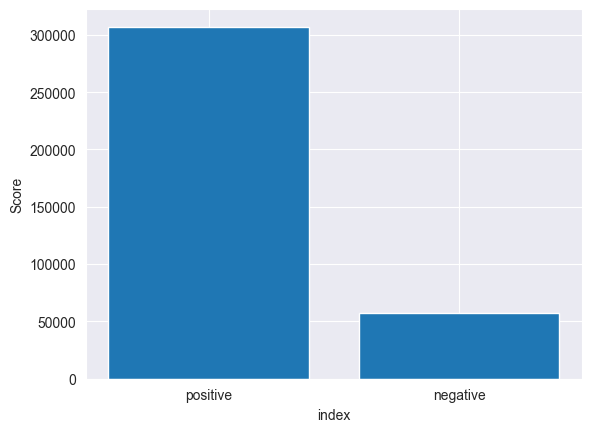

In [12]:
# hãy kiểm tra xem các đánh giá tích cực và tiêu cực được phân phối như thế nào
plt.bar(final['Score'].value_counts().index, final['Score'].value_counts().values)
plt.xlabel('index')
plt.ylabel('Score')
plt.show()


In [13]:
# Tìm các câu chứa thẻ HTML và dấu câu
import re
i = 0
# Duyệt qua từng câu trong cột "Text"
for sent in final['Text'].values:
    # Kiểm tra nếu câu chứa cả thẻ HTML và dấu câu
    if (len(re.findall('<.*?>', sent))) and (len(re.findall('[?|!|\'|"|#]', sent))):
        print('Vị trí:', i)
        print(sent)
        # Dừng vòng lặp
        break
    i += 1


Vị trí: 6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [14]:
# Nhập thư viện nltk và tải tập dừng từ tiếng Anh
import nltk
nltk.download('stopwords')

# Khởi tạo tập từ dừng
stop = set(stopwords.words('english'))  # Tập từ dừng trong tiếng Anh
sno = nltk.stem.SnowballStemmer('english')  # Khởi tạo bộ gốc Snowball cho tiếng Anh

# Hàm để loại bỏ thẻ HTML khỏi câu
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')  # Mẫu để loại bỏ thẻ HTML
    cleantext = re.sub(cleanr, ' ', sentence)  # Loại bỏ thẻ HTML từ câu
    return cleantext

# Hàm để loại bỏ dấu câu hoặc ký tự đặc biệt khỏi câu
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/]', r'', sentence)  # Loại bỏ dấu câu và ký tự đặc biệt từ câu
    return cleaned

# Áp dụng các hàm làm sạch văn bản cho một câu cụ thể và in ra kết quả
res = cleanhtml(final['Text'].values[6])  # Loại bỏ thẻ HTML từ câu
res = cleanpunc(res)  # Loại bỏ dấu câu và ký tự đặc biệt từ câu
print(res)


I set aside at least an hour each day to read to my son 3 yo At this point I consider myself a connoisseur of childrens books and this is one of the best Santa Clause put this under the tree Since then weve read it perpetually and he loves it  First this book taught him the months of the year  Second its a pleasure to read Well suited to 15 yo old to 4+  Very few childrens books are worth owning Most should be borrowed from the library This book however deserves a permanent spot on your shelf Sendaks best


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Làm sạch html, dấu câu, từ dừng và bắt nguồn từng từ trong mỗi bài đánh giá
Trong đây sau khi làm sạch dấu câu các thứ sẽ import vào sqlite để lưu danh sách 

In [15]:

# làm sạch html, dấu câu, từ dừng và bắt nguồn từng từ trong mỗi bài đánh giá
# xin lưu ý rằng đối với Word2Vec, sẽ không bao gồm tất cả các bước này để xử lý trước.
# lưu trữ những đánh giá cuối cùng này trong cơ sở dữ liệu Final.sqlite

if not os.path.isfile('final.sqlite'):
    # Khởi tạo danh sách để lưu các bài đánh giá đã được làm sạch
    cleaned_reviews = []
    cleaned_reviews_w2v = []
    
    # Duyệt qua từng câu trong cột "Text" của DataFrame final
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence = []  # Danh sách để lưu các từ đã được làm sạch
        filtered_sentence_w2v = []  # Danh sách để lưu các từ dành cho Word2Vec
        sent = cleanhtml(sent)  # Loại bỏ thẻ HTML từ câu
        
        # Duyệt qua mỗi từ trong câu
        for word in sent.split():
            # Loại bỏ dấu câu và chia thành các từ riêng biệt
            for cleaned_words in cleanpunc(word).split():
                # Kiểm tra xem từ đó chỉ chứa các ký tự chữ cái và có độ dài lớn hơn 2 không
                if (cleaned_words.isalpha()) and (len(cleaned_words) > 2):
                    # Thêm từ đã làm sạch vào danh sách filtered_sentence_w2v
                    filtered_sentence_w2v.append(cleaned_words.lower())
                    # Kiểm tra xem từ đã làm sạch không nằm trong tập từ dừng
                    if cleaned_words.lower() not in stop:
                        # Stem từ và chuyển thành byte
                        stem_word = (sno.stem(cleaned_words.lower())).encode('utf8')
                        # Thêm từ đã làm sạch và gốc từ đã stem vào danh sách filtered_sentence
                        filtered_sentence.append(stem_word)
        
        # Chuyển danh sách các từ đã làm sạch thành một câu và lưu vào cleaned_reviews
        filtered_sentence = b' '.join(filtered_sentence)
        # Chuyển danh sách các từ dành cho Word2Vec thành một câu và lưu vào cleaned_reviews_w2v
        filtered_sentence_w2v = ' '.join(filtered_sentence_w2v)
        cleaned_reviews.append(filtered_sentence)
        cleaned_reviews_w2v.append(filtered_sentence_w2v)
    
    # Thêm cột mới "CleanedText" chứa các bài đánh giá đã được làm sạch vào DataFrame final
    final['CleanedText'] = cleaned_reviews
    # Chuyển dữ liệu của cột "CleanedText" thành kiểu str
    final['CleanedText'] = final['CleanedText'].str.decode("utf-8")
    # Thêm cột mới "CleanedText_w2v" chứa các bài đánh giá đã được làm sạch cho Word2Vec vào DataFrame final
    final['CleanedText_w2v'] = cleaned_reviews_w2v

    # Lưu trữ DataFrame final vào cơ sở dữ liệu final.sqlite
    conn = sqlite3.connect('final.sqlite')
    c = conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    print('Done..!!')
else:
    print('File already Exist')


100%|██████████| 364171/364171 [02:51<00:00, 2125.85it/s]


Done..!!


In [16]:
# Tạo một hàm để trực quan hóa kết quả của TSNE
def tsne_visualizer(data, label, title):
    # Import thư viện TSNE từ sklearn.manifold
    from sklearn.manifold import TSNE

    # Tạo mô hình TSNE với 2 thành phần và 2000 lượt lặp
    tsne_model = TSNE(n_components=2, n_iter=2000)
    tsne_data = tsne_model.fit_transform(data)  # Áp dụng TSNE cho dữ liệu đầu vào

    # Tạo DataFrame để lưu trữ dữ liệu TSNE
    tsne_df = pd.DataFrame(data=np.vstack((tsne_data.T, label)).T, columns=['1st_component', '2nd_component', 'label'])

    # Trực quan hóa dữ liệu sử dụng seaborn
    sns.scatterplot(data=tsne_df, x='1st_component', y='2nd_component', hue='label')
    plt.title(title)
    plt.show()

#tsne_visualizer(data=bow_standerdised_data, label=df_final['Score'].values)


## 3. Chuyển đổi đánh giá thành vectơ và phân loại cảm xúc bằng KNN

### ***Mục tiêu:*** Chuyển đổi từng đánh giá hoặc câu thành một vectơ và sử dụng K Nearest Neighbor để phân loại.

Trong phần này, chúng tôi sẽ chuyển đổi các đánh giá đã được làm sạch của mình thành vectơ bằng cách sử dụng ***Bag Of Words, TF-IDF, Average Word2Vec và TF-IDF Weighted*** Word2Vec để chúng tôi có thể biểu diễn chúng trong mặt phẳng n chiều và sau đó sử dụng Knearest Hàng xóm để phân loại các đánh giá tích cực và tiêu cực.


Dưới đây là các bước chúng tôi sẽ thực hiện cho từng kỹ thuật vector hóa:
1. Vector hóa: BOW, TF-IDF, Avg Word2Vec, Word2Vec có trọng số TF-IDF
2. Lấy mẫu quá mức: Lấy mẫu ngẫu nhiên
3. Tiêu chuẩn hóa
4. Giảm kích thước: PCA ; (sẽ bị bỏ qua đối với Word2Vec)
5. K-NN và Báo cáo phân loại
- Bag of Words (BOW): Biểu diễn mỗi đánh giá dưới dạng vectơ, trong đó mỗi phần tử tương ứng với số lần xuất hiện của từ trong từ điển.

- ![BOW.png](BOW.png)
- Term Frequency-Inverse Document Frequency (TF-IDF): Biểu diễn mỗi đánh giá dưới dạng vectơ, trong đó giá trị của mỗi phần tử phản ánh mức độ quan trọng của từ trong đánh giá và tài liệu toàn bộ.
- ![TF_IDF.gif](TF_IDF.gif)
- Average Word2Vec: Biểu diễn mỗi đánh giá dưới dạng vectơ, trong đó mỗi phần tử là trung bình của các vectơ nhúng từ (Word2Vec) của các từ trong đánh giá.
    - Ý tưởng cơ bản của word2vec có thể được gói gọn trong các ý sau:
        - Hai từ xuất hiện trong những văn cảnh giống nhau thường có ý nghĩa gần với nhau.
                - Ta có thể đoán được một từ nếu biết các từ xung quanh nó trong câu. Ví dụ, với câu “Hà Nội là … của Việt Nam” thì từ trong dấu ba chấm khả năng cao là “thủ đô”. 
        - Với câu hoàn chỉnh “Hà Nội là thủ đô của Việt Nam”, mô hình word2vec sẽ xây dựng ra embeding của các từ sao cho xác suất để từ trong dấu ba chấm là “thủ đô” là cao nhất.
    - Có hai cách khác nhau xây dựng mô hình word2vec:

        - Skip-gram: Dự đoán những từ ngữ cảnh nếu biết trước từ đích.

        - CBOW (Continuous Bag of Words): Dựa vào những từ ngữ cảnh để dự đoán từ đích.



- TF-IDF Weighted Word2Vec: Biểu diễn mỗi đánh giá dưới dạng vectơ, trong đó mỗi phần tử là trung bình có trọng số của các vectơ nhúng từ (Word2Vec) của các từ trong đánh giá, với trọng số được xác định bằng TF-IDF.

In [17]:
# đọc các dữ liệu đã làm sạch trong final

if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews """, conn)
    conn.close()
else:
    print("File Not Available in the location")

## (A) Bag Of Words

### Phân chia dựa trên thời gian
Phân tách dựa trên thời gian đề cập đến việc thực hành phân chia dữ liệu hoặc mẫu dựa trên tiêu chí thời gian. Mục tiêu chính của việc phân tách dựa trên thời gian là đảm bảo rằng thứ tự thời gian của dữ liệu được giữ nguyên trong quá trình phân tách. Bằng cách sử dụng tính năng phân tách dựa trên thời gian, các mô hình học máy có thể được đào tạo và đánh giá dựa trên dữ liệu gần giống với kịch bản trong thế giới thực mà chúng sẽ được triển khai. Cách tiếp cận này giúp nắm bắt các mô hình thời gian và sự phụ thuộc, đồng thời cung cấp ước tính đáng tin cậy về hiệu suất của mô hình trong các ứng dụng thực tế.

Các bước:
1. Sắp xếp dữ liệu theo thời gian
2. Tách dữ liệu đã sắp xếp của tôi thành dữ liệu huấn luyện, dữ liệu xác thực và dữ liệu kiểm tra. sẽ lấy 70% dữ liệu đầu tiên để train và validation, phần còn lại để test

hình dạng của tập dữ liệu cuối cùng : (7000, 13)
	Dữ liệu Train
Shape của dữ liệu: (3920, 13)
Phân phối lớp: 	
Score
positive    3492
negative     428
Name: count, dtype: int64
	Dữ liệu Cross Validation
Shape của dữ liệu: (980, 13)
Phân phối lớp: 	
Score
positive    838
negative    142
Name: count, dtype: int64
	Dữ liệu Test 
Shape của dữ liệu: (2100, 13)
Phân phối lớp: 	
Score
positive    1860
negative     240
Name: count, dtype: int64


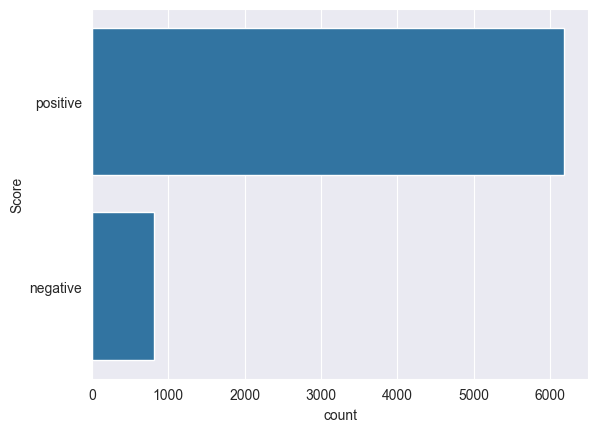

In [18]:
# sắp xếp dữ liệu theo thời gian vì nó là một biểu diễn tốt hơn của trường hợp sử dụng thực tế

# hãy thao tác trên 7000 điểm dữ liệu vì hạn chế bộ nhớ
df_final = final.sort_values(by='Time')[:7000]
print('hình dạng của tập dữ liệu cuối cùng :', df_final.shape)
print("="*20)

# lấy 70 phần trăm dữ liệu của chúng tôi cho train và 30 phần trăm cho test
# của 70 phần trăm dữ liệu, chúng tôi sẽ sử dụng 80 phần trăm cho train và 20 phần trăm cho cross validation
n_train = int(np.ceil(df_final.shape[0] * 0.70))
n_cv = int(n_train * 0.80)

df_train = df_final[:n_cv]
df_cv = df_final[n_cv:n_train]
df_test = df_final[n_train:]

# kiểm tra phân phối lớp của mỗi phần dữ liệu
df_lst = [('\tDữ liệu Train', df_train), ('\tDữ liệu Cross Validation', df_cv), ('\tDữ liệu Test ', df_test)]
for df_name, df in df_lst:
    print(df_name)
    print('Shape của dữ liệu:', df.shape)
    print('Phân phối lớp: \t')
    print(df['Score'].value_counts())
    print('='*20)

#vẽ biểu đồ số lượng điểm dữ liệu trong mỗi lớp
sns.countplot(df_final['Score'])
plt.show()


 ### Vector hóa using Bag Of Words

In [19]:
# Bag of Words
vectorizer_bow = CountVectorizer()
train_bow = vectorizer_bow.fit_transform(df_train['CleanedText'].values) # Chuyển đổi văn bản thành BOW
cv_bow = vectorizer_bow.transform(df_cv['CleanedText'].values)
test_bow = vectorizer_bow.transform(df_test['CleanedText'].values)

print("Kích thước của vectơ Bag of Words (train):", train_bow.shape)
print("Kích thước của vectơ Bag of Words (cross-validation):", cv_bow.shape)
print("Kích thước của vectơ Bag of Words (test):", test_bow.shape)


Kích thước của vectơ Bag of Words (train): (3920, 11309)
Kích thước của vectơ Bag of Words (cross-validation): (980, 11309)
Kích thước của vectơ Bag of Words (test): (2100, 11309)


### Oversampling
Các bộ dữ liệu không cân bằng, trong đó các lớp không được thể hiện như nhau, có thể đặt ra những thách thức trong các nhiệm vụ học máy. Số lượng đánh giá tiêu cực thấp đáng kể so với đánh giá tích cực và chúng tôi sẽ sử dụng Random Over Sampling để giải quyết vấn đề này.

RandomOverSampler: RandomOverSampler hoạt động bằng cách sao chép ngẫu nhiên các ví dụ từ lớp thiểu số cho đến khi nó đạt kích thước tương tự như lớp đa số. Kỹ thuật lấy mẫu tổng hợp này giúp giảm thiểu vấn đề mất cân bằng lớp, cho phép mô hình học hỏi từ cách biểu diễn dữ liệu cân bằng hơn.

Hình dạng của dữ liệu trước khi oversampling: (3920, 11309) 




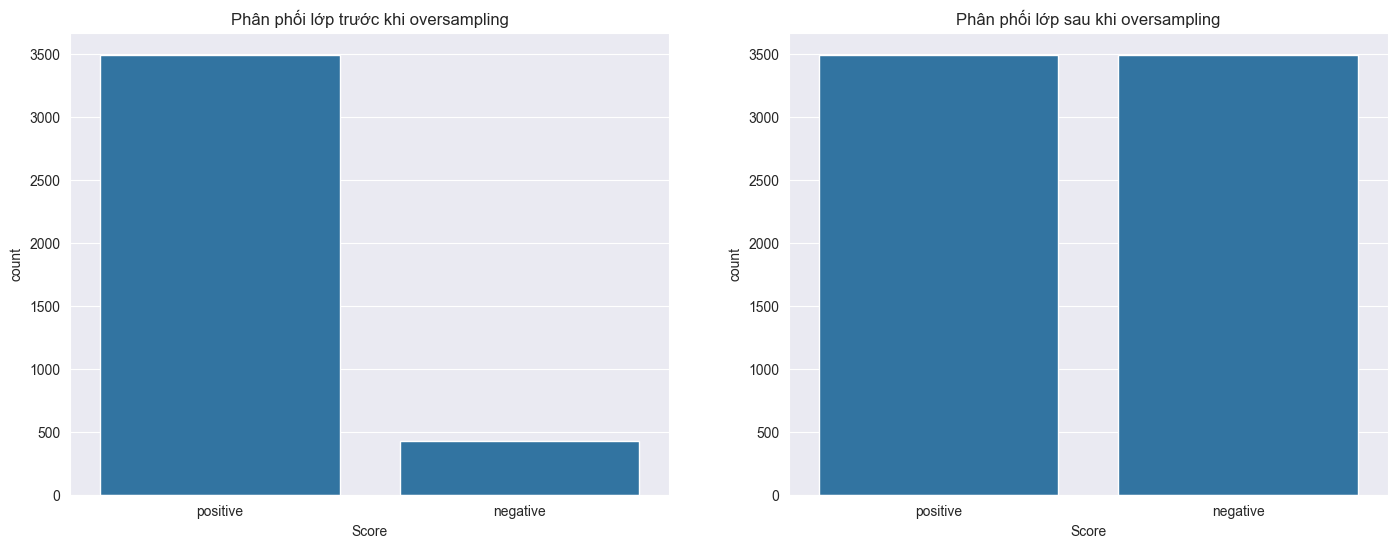

Hình dạng của dữ liệu sau khi oversampling: (6984, 11309)


In [20]:
# vẽ biểu đồ mất cân bằng lớp trước khi thực hiện oversampling
plt.figure(1, figsize=(17,6))  # Tạo một hình vẽ mới với kích thước 17x6
plt.subplot(1,2,1)  # Tạo một subplot với 1 hàng, 2 cột, và sử dụng ô thứ nhất
sns.countplot(x=df_train['Score'])  # Vẽ biểu đồ đếm số lượng mẫu trong mỗi lớp của dữ liệu huấn luyện trước khi thực hiện oversampling
plt.title('Phân phối lớp trước khi oversampling')  #
print('Hình dạng của dữ liệu trước khi oversampling:', train_bow.shape, '\n\n') 

# thực hiện oversampling bằng cách sử dụng SMOTE
# oversampling dữ liệu huấn luyện của chúng tôi
ros = RandomOverSampler()  # Khởi tạo một instance của RandomOverSampler
X_train_bow, Y_train_bow = ros.fit_resample(train_bow,df_train['Score'])  # Thực hiện oversampling dữ liệu huấn luyện bằng phương pháp Random Over-Sampling (ROS)

# vẽ biểu đồ phân phối lớp sau khi oversampling
plt.subplot(1,2,2)  # Chuyển sang ô subplot thứ hai
sns.countplot(x=Y_train_bow)  # Vẽ biểu đồ đếm số lượng mẫu trong mỗi lớp sau khi thực hiện oversampling
plt.title('Phân phối lớp sau khi oversampling')  
plt.show()  
print('Hình dạng của dữ liệu sau khi oversampling:', X_train_bow.shape)  # In ra hình dạng của dữ liệu sau khi thực hiện oversampling


### Standardization (Tiêu chuẩn hoá)

In [21]:
# Tạo một đối tượng StandardScaler để chuẩn hóa dữ liệu vectơ Bag of Words của tập huấn luyện
scaler_bow = StandardScaler()

# Chuẩn hóa dữ liệu vectơ Bag of Words của tập huấn luyện và chuyển đổi sang mảng numpy
X_train_bow_standardised = scaler_bow.fit_transform(X_train_bow.toarray())

# Sử dụng cùng một đối tượng StandardScaler để chuẩn hóa dữ liệu vectơ Bag of Words của tập cross-validation và chuyển đổi sang mảng numpy
X_cv_bow_standardised = scaler_bow.transform(cv_bow.toarray())

# Sử dụng cùng một đối tượng StandardScaler để chuẩn hóa dữ liệu vectơ Bag of Words của tập test và chuyển đổi sang mảng numpy
X_test_bow_standardised = scaler_bow.transform(test_bow.toarray())


### Giảm Kích Thước (Dimensionality Reduction)

Giảm kích thước là một kỹ thuật quan trọng trong học máy, được sử dụng để giải quyết vấn đề về kích thước của dữ liệu bằng cách giảm số lượng tính năng hoặc biến trong tập dữ liệu. Đối với các bộ dữ liệu có số chiều lớn, việc xử lý và phân tích có thể trở nên phức tạp và tốn kém. Đồng thời, việc giảm kích thước cũng giúp tăng hiệu suất tính toán và giảm thiểu hiện tượng trang bị quá mức.

Phương pháp giảm kích thước có thể trích xuất các tính năng quan trọng hoặc tạo ra các biểu diễn dữ liệu mới có số chiều thấp hơn, đồng thời vẫn giữ lại được phần lớn thông tin quan trọng từ dữ liệu gốc.

Trong trường hợp của chúng ta, quá trình vector hóa BOW đã tạo ra các vectơ có kích thước khoảng 11K. Để giảm kích thước và làm cho quá trình tính toán hiệu quả hơn, chúng ta sử dụng phương pháp PCA (Principal Component Analysis).

## PCA
PCA (Principal Component Analysis) là một phương pháp thống kê được sử dụng để giảm kích thước của dữ liệu bằng cách chuyển đổi các biến ban đầu thành một tập hợp nhỏ hơn các biến mới, gọi là các thành phần chính, sao cho các thành phần này giữ lại được phần lớn thông tin quan trọng từ dữ liệu gốc.

![PCA.png](PCA.png)

Cụ thể, PCA hoạt động bằng cách tìm ra các trục mới (các thành phần chính) trong không gian đa chiều của dữ liệu sao cho phương sai của dữ liệu trên các trục mới là lớn nhất. Các trục mới này được sắp xếp theo độ quan trọng giảm dần, từ trục có phương sai lớn nhất đến trục có phương sai nhỏ nhất.


3000
Dimensions required for 95 percent explained variance: 2260
Variance Explained: 0.9500869801405657


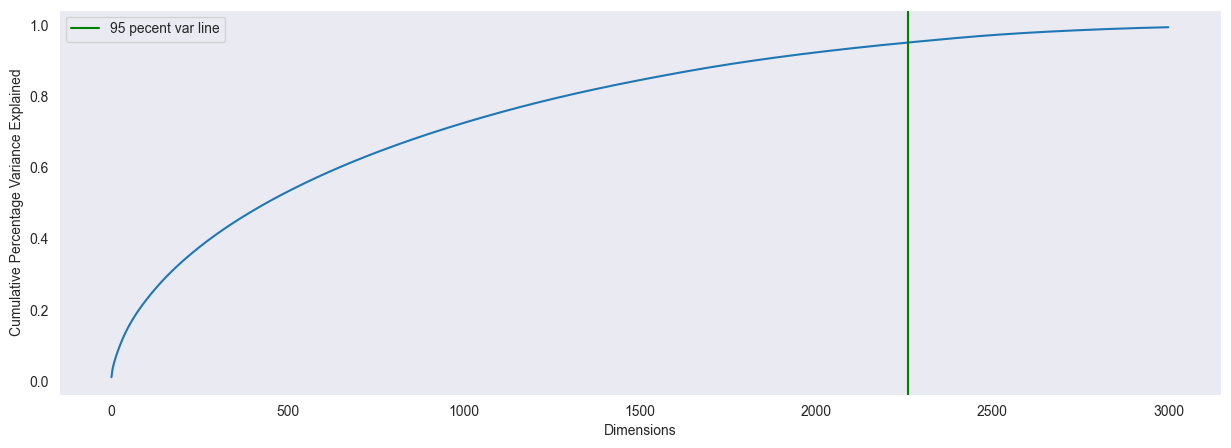

In [22]:
# Giảm kích thước sử dụng PCA hoặc chúng ta cũng có thể sử dụng SVD bị cắt ngắn

pca = PCA(n_components=3000) # Khởi tạo PCA với số lượng thành phần là 3000
pca.fit(X_train_bow_standardised) # Fit PCA với dữ liệu huấn luyện đã được chuẩn hóa

explained_variance = pca.explained_variance_ratio_ # Tính tỉ lệ phương sai được giải thích bởi mỗi thành phần chính
print(len(explained_variance))

# Tính số lượng thành phần cần thiết để giữ lại 95% phương sai được giải thích
dim_req_var = sum(np.cumsum(explained_variance) <=0.95)
print('Dimensions required for 95 percent explained variance:', dim_req_var)
print('Variance Explained:', np.cumsum(explained_variance)[dim_req_var])

# Vẽ biểu đồ thể hiện phần trăm phương sai tích lũy được giải thích theo số lượng thành phần chính
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(list(range(len(explained_variance))),np.cumsum(explained_variance))
plt.axvline(x = dim_req_var, color = 'g', label='95 pecent var line') # Vẽ đường thẳng đứng tại 95% phương sai tích lũy
plt.xlabel('Dimensions') 
plt.ylabel('Cumulative Percentage Variance Explained') #phương sai phần trăm tích lũy
plt.legend() # Hiển thị chú thích
plt.show()

# Giảm kích thước của dữ liệu train, cross-validation và test bằng cách chọn các thành phần chính tương ứng từ ma trận PCA
X_train_bow_pca = pca.transform(X_train_bow_standardised)[:, :dim_req_var]
X_cv_bow_pca = pca.transform(X_cv_bow_standardised)[:, :dim_req_var]
X_test_bow_pca = pca.transform(X_test_bow_standardised)[:, :dim_req_var]

y_train = Y_train_bow # Gán nhãn của dữ liệu huấn luyện
y_cv = df_cv['Score'].values # Gán nhãn của dữ liệu cross-validation
y_test = df_test['Score'].values # Gán nhãn của dữ liệu test


### K-Nearest Neighbors

K-Nearest Neighbors (KNN) là một thuật toán phổ biến và trực quan được sử dụng cho cả nhiệm vụ phân loại và hồi quy trong học máy. Đây là một thuật toán phi tham số, nghĩa là nó không đưa ra các giả định về phân bổ dữ liệu cơ bản. KNN đưa ra dự đoán dựa trên sự tương đồng giữa các phiên bản trong không gian đặc trưng. Chúng tôi sẽ sử dụng khoảng cách Euclide làm thước đo khoảng cách cho trường hợp sử dụng này.

1. Thuật toán K-Nearest Neighbors (KNN) sẽ được thực thi với một phạm vi k giá trị, cụ thể từ 1 đến 29 với kích thước bước là 2, đảm bảo chỉ xem xét các giá trị lẻ.
2. Sau đó, mô hình KNN sẽ được huấn luyện bằng cách sử dụng dữ liệu huấn luyện và dữ liệu xác thực sẽ được sử dụng để đánh giá độ chính xác, điểm f1 (dương) và điểm f1 (âm) cho mỗi giá trị của k.
3. Giá trị k liên quan đến độ chính xác cao nhất sẽ được chọn và k tối ưu này sẽ được sử dụng để tạo ra số liệu độ chính xác cuối cùng. Ngoài ra, một báo cáo phân loại toàn diện và ma trận nhầm lẫn sẽ được tạo bằng dữ liệu thử nghiệm.

100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


Độ chính xác tối đa là 0.8357142857142857 với giá trị K là 1
F1 score tối đa trên dữ liệu CV cho nhãn positive là 0.9100055897149245 với giá trị K là 1
F1 score tối đa trên dữ liệu CV cho nhãn negative là 0.269449715370019 với giá trị K là 17

Confusion matrix:
               pred_positive  pred_negative
true_positive           1785             75
true_negative            211             29

Classification Report:
              precision    recall  f1-score   support

    negative       0.28      0.12      0.17       240
    positive       0.89      0.96      0.93      1860

    accuracy                           0.86      2100
   macro avg       0.59      0.54      0.55      2100
weighted avg       0.82      0.86      0.84      2100


Accuracy on Test Data: 0.8638095238095238


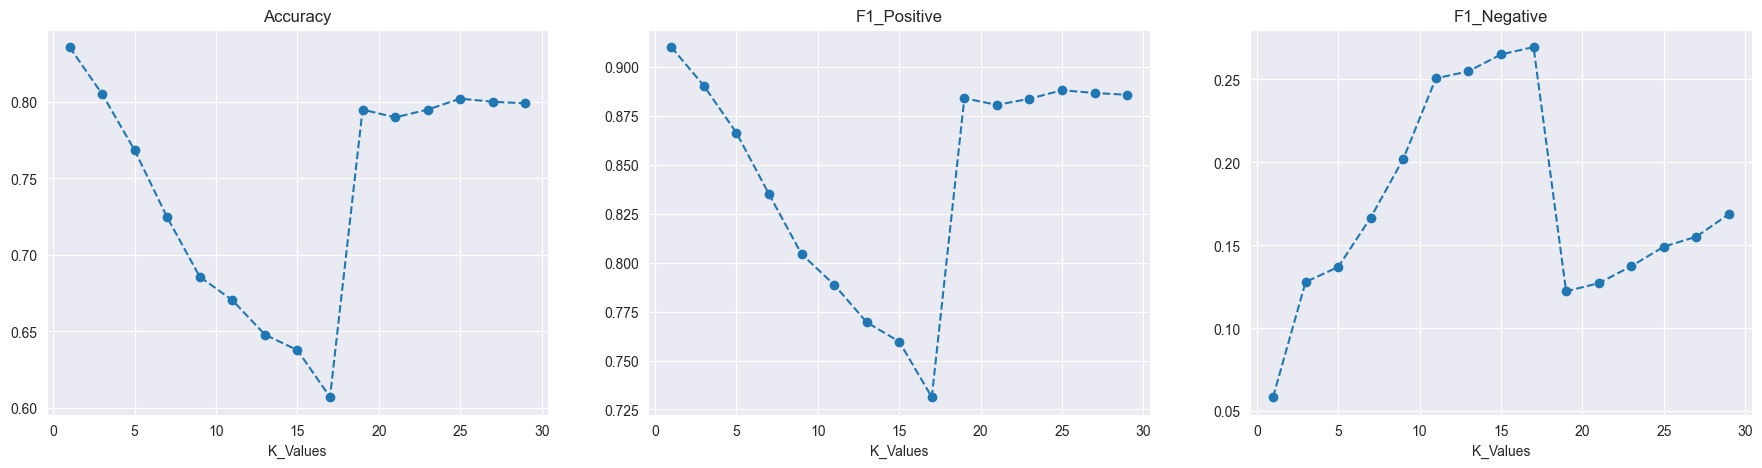

In [23]:
# Sử dụng KNN để phân loại dữ liệu
accuracy = [] 
f1_positive = [] # Danh sách để lưu trữ F1-score cho nhãn positive
f1_negative = [] # Danh sách để lưu trữ F1-score cho nhãn negative
K_values = list(range(1,30,2)) # Danh sách các giá trị K

# Vòng lặp qua các giá trị K để tìm ra giá trị tốt nhất
for k in tqdm(K_values):
    knn = KNeighborsClassifier(n_neighbors=k) # Khởi tạo mô hình KNN với số lượng neighbors là k
    knn.fit(X_train_bow_pca, y_train) # Huấn luyện mô hình trên dữ liệu train
    pred = knn.predict(X_cv_bow_pca) # Dự đoán nhãn cho dữ liệu cross-validation
    f1_positive.append(f1_score(y_cv, pred, pos_label="positive")) # Tính và lưu trữ F1-score cho nhãn positive
    f1_negative.append(f1_score(y_cv, pred, pos_label="negative")) # Tính và lưu trữ F1-score cho nhãn negative
    accuracy.append(accuracy_score(y_cv, pred)) # Tính và lưu trữ độ chính xác

positive_ind = f1_positive.index(max(f1_positive)) # Lấy chỉ số của giá trị F1-score lớn nhất cho nhãn positive
negative_ind = f1_negative.index(max(f1_negative)) # Lấy chỉ số của giá trị F1-score lớn nhất cho nhãn negative
acc_ind = accuracy.index(max(accuracy)) # Lấy chỉ số của giá trị độ chính xác lớn nhất

# In ra kết quả tốt nhất đạt được
print('Độ chính xác tối đa là {a} với giá trị K là {b}'.format(a=max(accuracy), b=K_values[acc_ind]))
print('F1 score tối đa trên dữ liệu CV cho nhãn positive là {a} với giá trị K là {b}'.format(a=max(f1_positive), b=K_values[positive_ind]))
print('F1 score tối đa trên dữ liệu CV cho nhãn negative là {a} với giá trị K là {b}'.format(a=max(f1_negative), b=K_values[negative_ind]))

# Vẽ biểu đồ hiển thị accuracy, F1-score cho các giá trị K
plt.figure(1, figsize=(22,5))
plt.subplot(1,3,1)
plt.plot(K_values, accuracy, 'o--')
plt.title('Accuracy')
plt.xlabel('K_Values')

plt.subplot(1,3,2)
plt.plot(K_values, f1_positive, 'o--')
plt.title('F1_Positive')
plt.xlabel('K_Values')

plt.subplot(1,3,3)
plt.plot(K_values, f1_negative, 'o--')
plt.title('F1_Negative')
plt.xlabel('K_Values')

# Huấn luyện mô hình KNN trên dữ liệu kiểm tra và tạo các ma trận liên quan
knn = KNeighborsClassifier(n_neighbors=K_values[acc_ind])
knn.fit(X_train_bow_pca, y_train)
pred = knn.predict(X_test_bow_pca)

# Tạo confusion matrix và báo cáo phân loại để đánh giá hiệu suất
confusion_mat = pd.DataFrame(confusion_matrix(y_test, pred, labels=['positive', 'negative']), columns=['pred_positive', 'pred_negative'], index=['true_positive', 'true_negative'])
print('\nConfusion matrix:')
print(confusion_mat)
print('\nClassification Report:')
print(classification_report(y_test, pred))
print('\nAccuracy on Test Data:', accuracy_score(y_test, pred))




### Precision là tỷ lệ giữa số lượng dự đoán chính xác của một lớp và tổng số dự đoán của lớp đó
### Recall là tỷ lệ giữa số lượng dự đoán chính xác của một lớp và tổng số điểm thực sự thuộc lớp đó trong dữ liệu.
### F1-score là một trung bình điều hòa giữa precision và recall. 
 Trong trường hợp này, precision và recall cho nhãn negative khá thấp, chỉ khoảng 21% và 9% tương ứng.

### ***Bow Result:***
Mô hình phân loại đã đạt được độ chính xác ***86%*** trên tập dữ liệu, cho thấy rằng nó đã phân loại chính xác 86% trường hợp, mặc dù độ chính xác cho thấy mô hình đã hoạt động tốt, hãy xem xét sự sai lệch.

Khi xem xét ma trận nhầm lẫn, chúng tôi nhận thấy rằng trong số các trường hợp dương tính thực tế, mô hình đã dự đoán chính xác 1.787 là dương tính (dương tính thật), nhưng lại phân loại sai 75 là âm tính (âm tính giả). Ngoài ra, trong số các trường hợp âm tính thực tế, mô hình đã dự đoán chính xác 26 là âm tính (âm tính thật), trong khi phân loại sai 214 là dương tính (dương tính giả).

Độ chính xác của lớp dương tính là 89%, cho thấy rằng trong số tất cả các trường hợp được dự đoán là dương tính thì 89% thực sự là dương tính. Tỷ lệ thu hồi đối với lớp tích cực là 96%, cho thấy mô hình đã xác định chính xác 96% trường hợp tích cực. Điểm f1 cho lớp tích cực là 93%, kết hợp độ chính xác và khả năng thu hồi thành một số liệu duy nhất và điều này cho thấy rằng mô hình dự đoán lớp tích cực thực sự tốt.

Mặt khác, độ chính xác của lớp âm tương đối thấp ở mức 28%, ngụ ý rằng chỉ 28% trường hợp được dự đoán là âm là thực sự âm. Tỷ lệ thu hồi đối với lớp phủ định là 12%, cho thấy mô hình đã gặp khó khăn trong việc xác định chính xác các trường hợp phủ định. Điểm f1 cho lớp phủ định là 17%. Điều này cho thấy rằng mô hình của chúng tôi rất kém trong việc dự đoán loại hoặc đánh giá tiêu cực.

Để chẩn đoán sự cố, chúng tôi có thể sử dụng nhiều kỹ thuật khác nhau nhưng hãy trực quan hóa dữ liệu đào tạo của chúng tôi ở dạng 2D để hiểu rõ hơn mức độ phân tách giữa các đánh giá tích cực và tiêu cực.

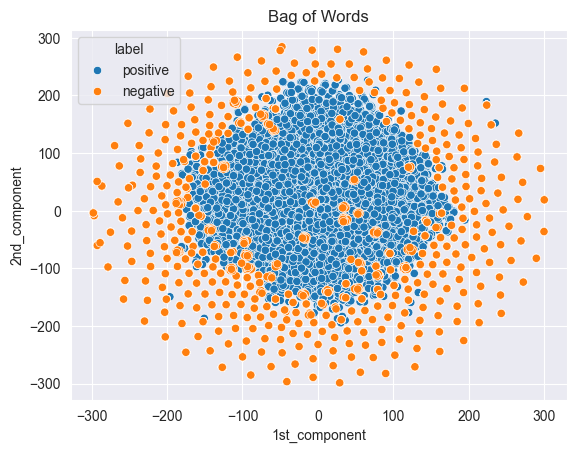

In [24]:
# visualizing BOW with TSNE

title = 'Bag of Words'
tsne_visualizer(data=X_train_bow_pca, label=y_train, title=title)

## (B) TF-IDF
 (Term Frequency-Inverse Document Frequency) có chức năng chuyển đổi các văn bản thành các vectơ số dựa trên tần suất xuất hiện của các từ trong văn bản. Cụ thể, TF-IDF sẽ đo lường mức độ quan trọng của một từ trong một văn bản so với toàn bộ tập dữ liệu.

Trong dự án phân loại cảm xúc của đánh giá sản phẩm, TF-IDF có thể giúp:
- Tạo biểu diễn dữ liệu: Chuyển đổi mỗi đánh giá thành một vectơ TF-IDF, trong đó mỗi phần tử đại diện cho mức độ quan trọng của mỗi từ trong đánh giá đó.
- Giảm chiều dữ liệu: Giảm kích thước của dữ liệu bằng cách giữ lại các tính năng quan trọng nhất, giúp cải thiện hiệu suất mô hình và giảm thời gian tính toán.
- Phân loại cảm xúc: Dùng để phân loại đánh giá thành các nhóm cảm xúc khác nhau (ví dụ: tích cực, tiêu cực).

In [25]:
# Tạo một TfidfVectorizer để chuyển đổi các văn bản thành vectơ TF-IDF
vectorizer_tfidf = TfidfVectorizer()

# Chuyển đổi dữ liệu huấn luyện thành vectơ TF-IDF bằng phương pháp fit_transform
train_tfidf = vectorizer_tfidf.fit_transform(df_train['CleanedText'].values)

# Chuyển đổi dữ liệu kiểm định và dữ liệu kiểm định chéo thành vectơ TF-IDF bằng phương thức transform
cv_tfidf = vectorizer_tfidf.transform(df_cv['CleanedText'].values)
test_tfidf = vectorizer_tfidf.transform(df_test['CleanedText'].values)

# In ra hình dạng của các vectơ TF-IDF cho từng tập dữ liệu
print('Shape của train sau khi chuyển sang TF-IDF:',train_tfidf.shape)
print('Shape của cross-validation sau khi chuyển sang TF-IDF:',cv_tfidf.shape)
print('Shape của test sau khi chuyển sang TF-IDF:',test_tfidf.shape)


Shape của train sau khi chuyển sang TF-IDF: (3920, 11309)
Shape của cross-validation sau khi chuyển sang TF-IDF: (980, 11309)
Shape của test sau khi chuyển sang TF-IDF: (2100, 11309)


Shape of data before oversampling: (3920, 11309) 




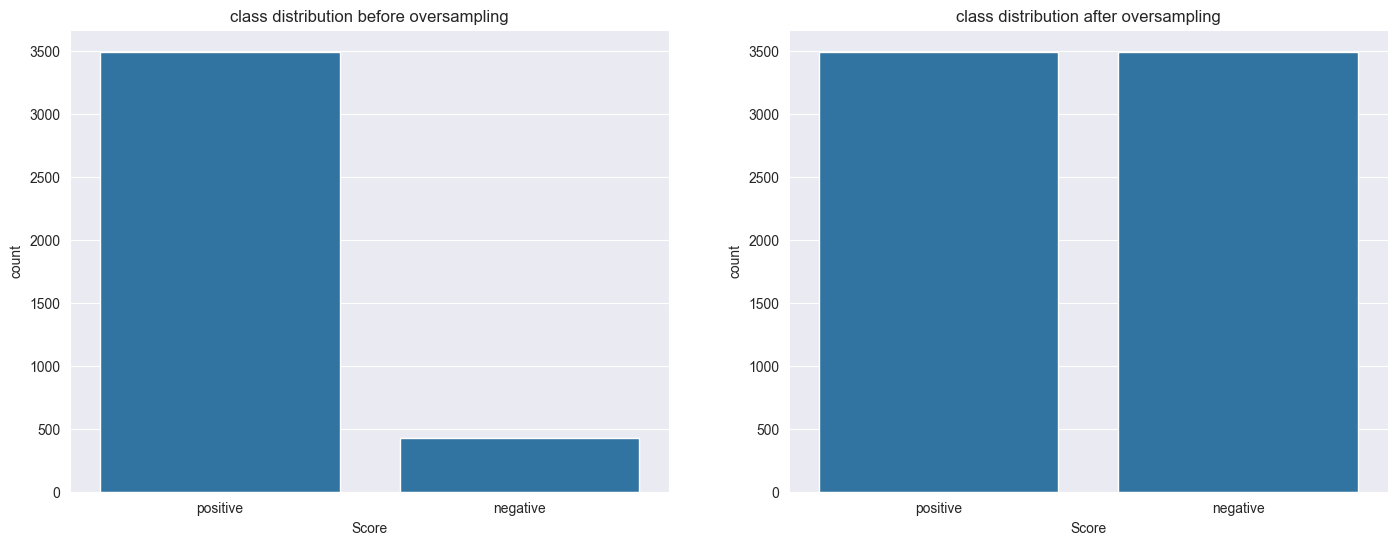

Shape of data after oversampling: (6984, 11309)


In [26]:
## OVERSAMPLING

# plotting class imbalance before oversampling
plt.figure(1, figsize=(17,6)) # Tạo một figure với kích thước (17, 6) để chứa các subplot
plt.subplot(1,2,1) # Tạo subplot đầu tiên trong figure, có 1 hàng, 2 cột, và vị trí 1
sns.countplot(x=df_train['Score']) # Trực quan hóa số lượng mẫu cho mỗi lớp (giá trị của 'Score') trong tập dữ liệu huấn luyện
plt.title('class distribution before oversampling') 
print('Shape of data before oversampling:', train_tfidf.shape, '\n\n') # In ra hình dạng của dữ liệu huấn luyện trước khi thực hiện oversampling

# performing oversampling using smote
# oversampling our train data
ros = RandomOverSampler() # Khởi tạo một instance của RandomOverSampler
X_train_tfidf, Y_train_tfidf = ros.fit_resample(train_tfidf,df_train['Score']) # Thực hiện oversampling cho dữ liệu huấn luyện và nhãn tương ứng


plt.subplot(1,2,2) # Tạo subplot thứ hai trong figure, có 1 hàng, 2 cột, và vị trí 2
sns.countplot(x=Y_train_tfidf) # Trực quan hóa số lượng mẫu cho mỗi lớp (giá trị của 'Score') trong tập dữ liệu huấn luyện sau khi oversampling
plt.title('class distribution after oversampling') 
plt.show()
print('Shape of data after oversampling:', X_train_tfidf.shape) 


In [27]:
scaler_tfidf = StandardScaler() # Khởi tạo một instance của StandardScaler để chuẩn hóa dữ liệu
X_train_tfidf_standardised = scaler_tfidf.fit_transform(X_train_tfidf.toarray()) # Chuẩn hóa dữ liệu huấn luyện và chuyển đổi thành mảng numpy
X_cv_tfidf_standardised = scaler_tfidf.transform(cv_tfidf.toarray()) # Chuẩn hóa dữ liệu cross-validation và chuyển đổi thành mảng numpy
X_test_tfidf_standardised = scaler_tfidf.transform(test_tfidf.toarray()) # Chuẩn hóa dữ liệu kiểm tra và chuyển đổi thành mảng numpy


Dimensions required for 95 percent explained variance: 2613
Variance Explained: 0.9500858662884929


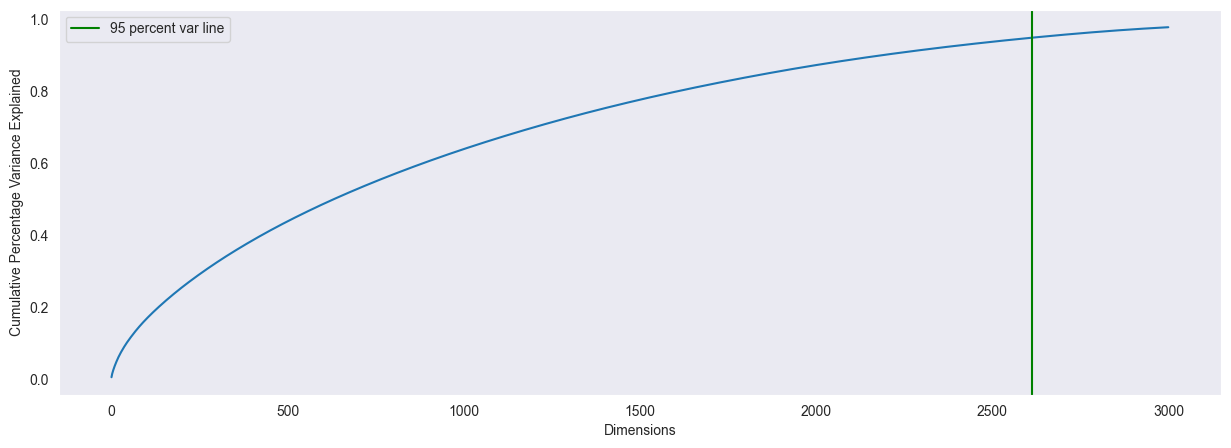

In [28]:
pca = PCA(n_components=3000)  # Khởi tạo một đối tượng PCA với 3000 thành phần
pca.fit(X_train_tfidf_standardised)  # Huấn luyện PCA trên dữ liệu TF-IDF đã được chuẩn hóa
explained_variance = pca.explained_variance_ratio_  # Tính tỷ lệ phương sai được giải thích bởi từng thành phần chính

# Tìm số lượng thành phần chính cần thiết để giải thích 95% phương sai
dim_req_var = sum(np.cumsum(explained_variance) <= 0.95)
print('Dimensions required for 95 percent explained variance:', dim_req_var)
print('Variance Explained:', np.cumsum(explained_variance)[dim_req_var])

# Vẽ biểu đồ hiển thị phương sai được giải thích tích lũy theo số lượng thành phần chính
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(list(range(len(explained_variance))), np.cumsum(explained_variance))
plt.axvline(x=dim_req_var, color='g', label='95 percent var line')  # Vẽ đường dọc tại 95% phương sai được giải thích
plt.xlabel('Dimensions')
plt.ylabel('Cumulative Percentage Variance Explained')
plt.legend()
plt.show()

# Áp dụng phép chiếu PCA để giảm kích thước của dữ liệu
X_train_tfidf_pca = pca.transform(X_train_tfidf_standardised)[:, :dim_req_var]  # Chiếu dữ liệu huấn luyện
X_cv_tfidf_pca = pca.transform(X_cv_tfidf_standardised)[:, :dim_req_var]  # Chiếu dữ liệu cross-validation
X_test_tfidf_pca = pca.transform(X_test_tfidf_standardised)[:, :dim_req_var]  # Chiếu dữ liệu kiểm tra
y_train = Y_train_tfidf  # Gán nhãn cho dữ liệu huấn luyện
y_cv = df_cv['Score'].values  # Gán nhãn cho dữ liệu cross-validation
y_test = df_test['Score'].values  # Gán nhãn cho dữ liệu kiểm tra


100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


The maximum accuracy is 0.826530612244898 with K value of 25
The maximum F1 score on CV data for positive labels is 0.9048152295632699 with K value of 25
The maximum F1 score on CV data for negative labels is 0.27232142857142855 with K value of 3

Confusion matrix:
               pred_positive  pred_negative
true_positive           1805             55
true_negative            224             16

Classification Report:
              precision    recall  f1-score   support

    negative       0.23      0.07      0.10       240
    positive       0.89      0.97      0.93      1860

    accuracy                           0.87      2100
   macro avg       0.56      0.52      0.52      2100
weighted avg       0.81      0.87      0.83      2100


Accuracy on Test Data: 0.8671428571428571


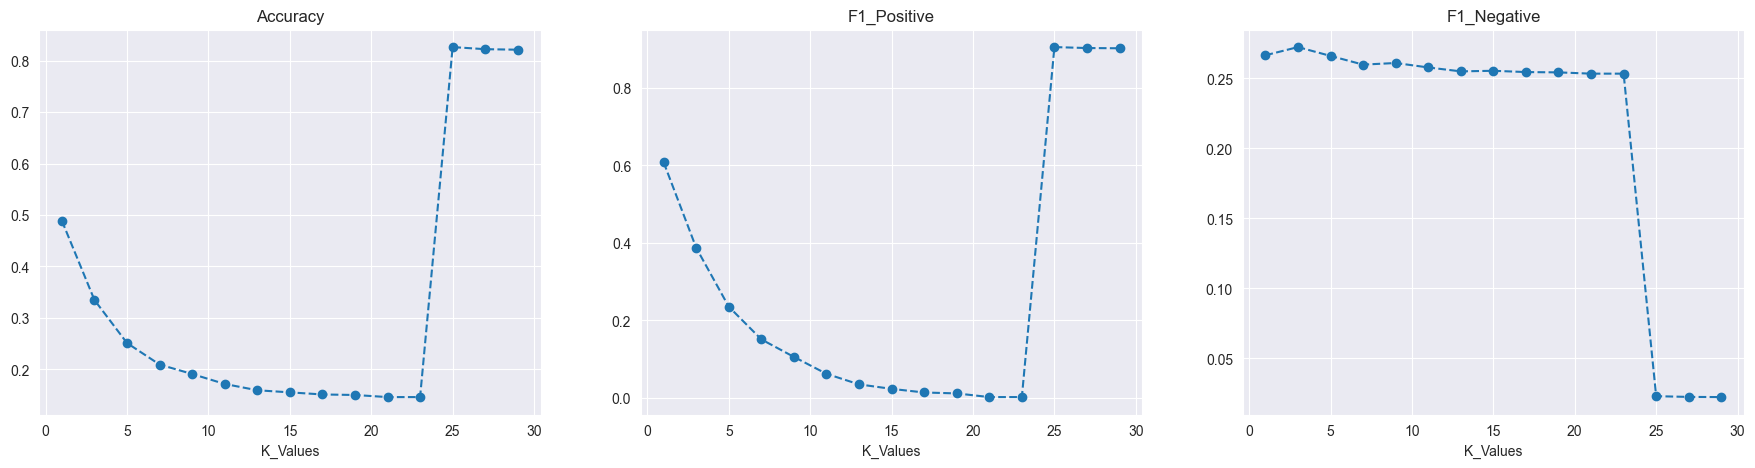

In [29]:
# Using KNN for classification
accuracy = []
f1_positive = []
f1_negative = []
K_values = list(range(1,30,2))

for k in tqdm(K_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_tfidf_pca, y_train)
    pred = knn.predict(X_cv_tfidf_pca)
    f1_positive.append(f1_score(y_cv, pred, pos_label="positive"))
    f1_negative.append(f1_score(y_cv, pred, pos_label="negative"))
    accuracy.append(accuracy_score(y_cv, pred))

positive_ind = f1_positive.index(max(f1_positive))
negative_ind = f1_negative.index(max(f1_negative))
acc_ind = accuracy.index(max(accuracy))
print('The maximum accuracy is {a} with K value of {b}'.format(a=max(accuracy), b=K_values[acc_ind]))
print('The maximum F1 score on CV data for positive labels is {a} with K value of {b}'.format(a=max(f1_positive), b=K_values[positive_ind]))
print('The maximum F1 score on CV data for negative labels is {a} with K value of {b}'.format(a=max(f1_negative), b=K_values[negative_ind]))

# plotting accuracy f1-positive and f1-negative for K values
plt.figure(1, figsize=(22,5))
plt.subplot(1,3,1)
plt.plot(K_values, accuracy, 'o--')
plt.title('Accuracy')
plt.xlabel('K_Values')

plt.subplot(1,3,2)
plt.plot(K_values, f1_positive, 'o--')
plt.title('F1_Positive')
plt.xlabel('K_Values')

plt.subplot(1,3,3)
plt.plot(K_values, f1_negative, 'o--')
plt.title('F1_Negative')
plt.xlabel('K_Values')

# knn on our test data for reporting
# plase note that we can fit it on best value of our negativef1 score as well
# in order to boost the precision and recall for our negative reviews
knn = KNeighborsClassifier(n_neighbors=K_values[acc_ind])
knn.fit(X_train_tfidf_pca, y_train)
pred = knn.predict(X_test_tfidf_pca)

# generating relevant martices
confusion_mat = pd.DataFrame(confusion_matrix(y_test, pred, labels=['positive', 'negative']), columns=['pred_positive', 'pred_negative'], index=['true_positive', 'true_negative'])
print('\nConfusion matrix:')
print(confusion_mat)
print('\nClassification Report:')
print(classification_report(y_test, pred))
print('\nAccuracy on Test Data:', accuracy_score(y_test, pred))

### ***Kết quả với TF-IDF:***
Mô hình phân loại đạt được độ chính xác là 88,0% trên dữ liệu thử nghiệm, tức là nó đã phân loại chính xác 88,0% số trường hợp.

Khi xem xét ma trận nhầm lẫn, chúng ta thấy rằng:
- Trong số các trường hợp thực tế là tích cực, mô hình đã dự đoán đúng 1835 trường hợp là tích cực (đúng tích cực), nhưng lại dự đoán sai 25 trường hợp là tiêu cực (sai tiêu cực).
- Đối với các trường hợp thực tế là tiêu cực, mô hình đã dự đoán đúng 4 trường hợp là tiêu cực (đúng tiêu cực), nhưng lại dự đoán sai 236 trường hợp là tích cực (sai tích cực).

Độ chính xác của lớp tích cực là 89%, tức là trong số tất cả các trường hợp được dự đoán là tích cực, 89% thực sự là tích cực. Tỷ lệ thu hồi của lớp tích cực là 99%, tức là mô hình đã xác định đúng 99% trường hợp tích cực. Điểm F1 cho lớp tích cực là 93%, tổng hợp độ chính xác và khả năng thu hồi thành một số liệu duy nhất.

Tuy nhiên, độ chính xác của lớp tiêu cực là chỉ 14%, ngụ ý rằng chỉ có 14% trường hợp được dự đoán là tiêu cực thực sự là tiêu cực. Tỷ lệ thu hồi của lớp tiêu cực là 2%, tức là mô hình gặp khó khăn trong việc xác định chính xác các trường hợp tiêu cực. Điểm F1 cho lớp tiêu cực là 3%. Tóm lại, mô hình này có hiệu suất chưa tốt khi phân loại các trường hợp tiêu cực.

Chúng ta có thể cân nhắc sử dụng thước đo khác như điểm F1 cho lớp tiêu cực để lựa chọn giá trị K tốt nhất và cải thiện dự đoán của mô hình đối với lớp tiêu cực.

Để chẩn đoán sự cố, chúng tôi có thể sử dụng nhiều kỹ thuật khác nhau nhưng hãy trực quan hóa dữ liệu đào tạo của chúng tôi ở dạng 2D để hiểu rõ hơn mức độ phân tách giữa các đánh giá tích cực và tiêu cực.

In [ ]:
# visualizing TFIDF train data with TSNE

title = 'TF-IDF'
tsne_visualizer(data=X_train_tfidf_pca, label=y_train, title=title)

## Chuyển đổi văn bản sang vectơ với Word2Vec
***Word2Vec:*** Word2Vec là một thuật toán được sử dụng rộng rãi trong xử lý ngôn ngữ tự nhiên (NLP) để tìm hiểu cách nhúng từ, là những cách biểu thị dày đặc của các từ bằng số. Nó dựa trên ý tưởng rằng những từ có nghĩa tương tự nhau thường xuất hiện trong những ngữ cảnh tương tự nhau. Word2Vec nắm bắt các mối quan hệ này bằng cách học cách dự đoán một từ dựa trên các từ lân cận của nó hoặc dự đoán các từ lân cận dựa trên một từ nhất định. Có hai cách chúng tôi sẽ sử dụng Word2Vec để chuyển đổi câu của mình

1. ***Word2Vec trung bình:*** Trong trường hợp Word2Vec trung bình, mục tiêu là tạo biểu diễn vectơ có độ dài cố định cho tài liệu bằng cách lấy trung bình các vectơ từ của tất cả các từ trong tài liệu.

2. ***Word2Vec có trọng số TF-IDF:*** Word2Vec có trọng số TF-IDF kết hợp các khái niệm của TF-IDF và Word2Vec để tạo các phần nhúng từ nắm bắt cả ý nghĩa ngữ nghĩa của các từ và tầm quan trọng của chúng trong kho tài liệu. Nó cải tiến mô hình Word2Vec truyền thống bằng cách kết hợp sơ đồ trọng số tần số tài liệu nghịch đảo tần số (TF-IDF).

## (C) Average Word2Vec

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
from tqdm import tqdm

def datastructure_generator_w2v(df):
    # Khởi tạo một danh sách rỗng để chứa các câu đã được mã hóa thành từng từ
    list_of_reviews = []
    
    # Lặp qua mỗi câu trong cột 'CleanedText_w2v' của DataFrame
    for sent in tqdm(df['CleanedText_w2v'].values):
        # Tách câu thành từng từ riêng lẻ và thêm danh sách kết quả vào list_of_reviews
        list_of_reviews.append(sent.split())
    
    # Trả về danh sách các câu đã được mã hóa thành từng từ
    return list_of_reviews


In [ ]:
# constructing required structures

list_of_sent =  datastructure_generator_w2v(final)
list_of_sent_train =  datastructure_generator_w2v(df_train)
list_of_sent_cv = datastructure_generator_w2v(df_cv)
list_of_sent_test = datastructure_generator_w2v(df_test)
avg_w2v_data_dict = {'train':list_of_sent_train, 'cv':list_of_sent_cv, 'test':list_of_sent_test}

list_of_sent_idf_train = df_train['CleanedText_w2v']
list_of_sent_idf_cv = df_cv['CleanedText_w2v']
list_of_sent_idf_test = df_test['CleanedText_w2v']

print('Done..!!')

In [ ]:
# training Word2Vec model on our data
# this may take time to execute
model_w2v=Word2Vec(list_of_sent,min_count=5,vector_size=50, workers=2)

In [ ]:
# construct avg w2v

# Lấy tập hợp các từ trong từ điển của mô hình Word2Vec
vocabulary_w2v = model_w2v.wv.key_to_index.keys()

# Khởi tạo một từ điển để lưu trữ các vector trung bình của các từ cho từng tập dữ liệu
avg_w2v_data_dict_final = {'train': None, 'cv': None, 'test': None}

# Duyệt qua từng tập dữ liệu trong từ điển chứa các câu đã được mã hóa thành từng từ
for key, item in avg_w2v_data_dict.items():
    print(key)  # In ra tên của tập dữ liệu đang xử lý

    # Khởi tạo danh sách để lưu trữ vector của từng câu
    review_vectors_w2v = []

    # Duyệt qua từng câu trong tập dữ liệu
    for sentence in tqdm(item):
        word_count = 0  # Biến đếm số từ trong câu
        sent_vec = np.zeros(shape=50)  # Khởi tạo vector của câu với toàn bộ giá trị là 0

        # Duyệt qua từng từ trong câu
        for word in sentence:
            # Kiểm tra xem từ có trong từ điển của mô hình Word2Vec không
            if word in vocabulary_w2v:
                # Nếu có, cập nhật vector của câu bằng vector của từ đó
                sent_vec += model_w2v.wv[word]
                word_count += 1  # Tăng biến đếm số từ lên

        # Tính toán vector trung bình của câu (nếu có ít nhất một từ trong từ điển)
        if word_count != 0:
            sent_vec = sent_vec / word_count

        # Thêm vector của câu vào danh sách
        review_vectors_w2v.append(sent_vec)

    # Chuyển danh sách thành mảng numpy
    review_vectors_w2v = np.array(review_vectors_w2v)
    print(review_vectors_w2v.shape)  # In ra kích thước của mảng numpy
    avg_w2v_data_dict_final[key] = review_vectors_w2v  # Lưu trữ vector trung bình của từng câu vào từ điển

# In ra thông báo khi hoàn thành quá trình tính toán
print('Done..!!')


In [ ]:
# sanity check
for key,item in avg_w2v_data_dict_final.items():
    print(key)
    print(item.shape)

In [ ]:
# Tạo các tham chiếu cho dữ liệu vector trung bình để truy cập dễ dàng
avg_w2v_data_train = avg_w2v_data_dict_final['train']  # Dữ liệu vector trung bình từ tập huấn luyện
avg_w2v_data_cv = avg_w2v_data_dict_final['cv']  # Dữ liệu vector trung bình từ tập cross-validation
avg_w2v_data_test = avg_w2v_data_dict_final['test']  # Dữ liệu vector trung bình từ tập kiểm tra


In [ ]:
# plotting class imbalance before oversampling
plt.figure(1, figsize=(17,6))  # Tạo một hình với số thứ tự 1 và kích thước là 17x6
plt.subplot(1,2,1)  # Tạo một khung hình ở vị trí đầu tiên trong lưới 1x2
plt.title('class distribution before oversampling')  # Đặt tiêu đề của biểu đồ là 'class distribution before oversampling'
sns.countplot(x=df_train['Score'])  # Tạo biểu đồ đếm số lượng mẫu trong mỗi lớp của cột 'Score' trong DataFrame df_train
print('Shape of data before oversampling:', avg_w2v_data_train.shape, '\n\n')  # In ra hình dạng của dữ liệu vector trung bình của tập huấn luyện trước khi thực hiện oversampling

# performing oversampling using smote
# oversampling our train data
ros = RandomOverSampler()  # Tạo một đối tượng RandomOverSampler để thực hiện oversampling
avg_w2v_data_train, Y_avg_w2v_data_train = ros.fit_resample(avg_w2v_data_train, df_train['Score'])  # Thực hiện oversampling cho dữ liệu tập huấn luyện và nhãn tương ứng

# plotting class dist after oversampling
plt.subplot(1,2,2)  # Tạo một khung hình ở vị trí thứ hai trong lưới 1x2
plt.title('class distribution after oversampling')  # Đặt tiêu đề của biểu đồ là 'class distribution after oversampling'
sns.countplot(x=Y_avg_w2v_data_train)  # Tạo biểu đồ đếm số lượng mẫu trong mỗi lớp sau khi thực hiện oversampling
plt.show()  # Hiển thị biểu đồ
print('Shape of data after oversampling:', avg_w2v_data_train.shape)  # In ra hình dạng của dữ liệu tập huấn luyện sau khi thực hiện oversampling


In [ ]:
# standardization
scaler_avg_w2v = StandardScaler()
X_train_avg_w2v_standardised = scaler_avg_w2v.fit_transform(avg_w2v_data_train)
X_cv_avg_w2v_standardised = scaler_avg_w2v.transform(avg_w2v_data_cv)
X_test_avg_w2v_standardised = scaler_avg_w2v.transform(avg_w2v_data_test)

y_train = Y_avg_w2v_data_train
y_cv = df_cv['Score'].values
y_test = df_test['Score'].values

In [ ]:
# Khởi tạo các danh sách rỗng để lưu trữ accuracy, F1-score cho positive và negative, 
# cùng với danh sách giá trị k mà chúng ta sẽ sử dụng để huấn luyện mô hình KNN.
accuracy = []
f1_positive = []
f1_negative = []
K_values = list(range(1, 30, 2))  # Tạo danh sách giá trị k từ 1 đến 29 với bước nhảy là 2

# Vòng lặp để huấn luyện và đánh giá mô hình KNN với các giá trị k khác nhau
for k in tqdm(K_values):
    # Khởi tạo mô hình KNN với số láng giềng là k
    knn = KNeighborsClassifier(n_neighbors=k)
    # Huấn luyện mô hình trên dữ liệu huấn luyện đã chuẩn hóa
    knn.fit(X_train_avg_w2v_standardised, y_train)
    # Dự đoán nhãn cho dữ liệu cross-validation
    pred = knn.predict(X_cv_avg_w2v_standardised)
    # Tính toán F1-score cho cả lớp positive và negative và lưu vào danh sách tương ứng
    f1_positive.append(f1_score(y_cv, pred, pos_label="positive"))
    f1_negative.append(f1_score(y_cv, pred, pos_label="negative"))
    # Tính toán accuracy và lưu vào danh sách
    accuracy.append(accuracy_score(y_cv, pred))

# Tìm vị trí của giá trị k tương ứng với accuracy và F1-score cao nhất cho cả lớp positive và negative
positive_ind = f1_positive.index(max(f1_positive))
negative_ind = f1_negative.index(max(f1_negative))
acc_ind = accuracy.index(max(accuracy))

# In ra giá trị accuracy và giá trị k tương ứng
print('Độ chính xác cao nhất là {a} với giá trị k là {b}'.format(a=max(accuracy), b=K_values[acc_ind]))
# In ra F1-score cao nhất và giá trị k tương ứng cho lớp positive
print('F1-score cao nhất trên dữ liệu CV cho nhãn positive là {a} với giá trị k là {b}'.format(a=max(f1_positive), b=K_values[positive_ind]))
# In ra F1-score cao nhất và giá trị k tương ứng cho lớp negative
print('F1-score cao nhất trên dữ liệu CV cho nhãn negative là {a} với giá trị k là {b}'.format(a=max(f1_negative), b=K_values[negative_ind]))

# Vẽ đồ thị biểu diễn accuracy, F1-score positive và F1-score negative cho từng giá trị k
plt.figure(1, figsize=(22, 5))
plt.subplot(1, 3, 1)
plt.plot(K_values, accuracy, 'o--')
plt.title('Độ chính xác')
plt.xlabel('Giá trị k')

plt.subplot(1, 3, 2)
plt.plot(K_values, f1_positive, 'o--')
plt.title('F1-score positive')
plt.xlabel('Giá trị k')

plt.subplot(1, 3, 3)
plt.plot(K_values, f1_negative, 'o--')
plt.title('F1-score negative')
plt.xlabel('Giá trị k')

# Huấn luyện mô hình KNN trên dữ liệu kiểm tra và in ra báo cáo phân loại
knn = KNeighborsClassifier(n_neighbors=K_values[acc_ind])
knn.fit(X_train_avg_w2v_standardised, y_train)
pred = knn.predict(X_test_avg_w2v_standardised)

# Tạo dataframe cho ma trận nhầm lẫn
confusion_mat = pd.DataFrame(confusion_matrix(y_test, pred, labels=['positive', 'negative']), 
                              columns=['Dự đoán positive', 'Dự đoán negative'], 
                              index=['Thực tế positive', 'Thực tế negative'])
print('\nMa trận nhầm lẫn:')
print(confusion_mat)

# In ra báo cáo phân loại
print('\nBáo cáo phân loại:')
print(classification_report(y_test, pred))

# In ra độ chính xác trên dữ liệu kiểm tra
print('\nĐộ chính xác trên dữ liệu kiểm tra:', accuracy_score(y_test, pred))


### ***Kết quả Word2Vector trung bình:***

Mô hình phân loại đạt được độ chính xác 88% trên dữ liệu thử nghiệm, cho thấy nó đã phân loại chính xác 88% trường hợp.

Phân tích ma trận nhầm lẫn, chúng tôi nhận thấy rằng trong số các trường hợp tích cực thực tế, mô hình đã dự đoán chính xác 1.762 trường hợp là dương tính (dương tính thực sự), nhưng nó đã phân loại sai 98 trường hợp là âm tính (âm tính giả). Tương tự, đối với các trường hợp âm tính thực tế, mô hình dự đoán chính xác 78 trường hợp là âm tính (âm tính thực), trong khi phân loại sai 162 trường hợp là dương tính (dương tính giả).

Độ chính xác của lớp dương tính là 92%, cho thấy rằng trong số tất cả các trường hợp được dự đoán là dương tính thì 92% thực sự là dương tính. Tỷ lệ thu hồi đối với lớp tích cực là 95%, cho thấy mô hình đã xác định chính xác 95% trường hợp tích cực. Điểm f1 cho lớp tích cực là 93%, kết hợp độ chính xác và khả năng thu hồi thành một số liệu duy nhất.

Mặt khác, độ chính xác của lớp âm là 44%, ngụ ý rằng chỉ 44% trường hợp được dự đoán là âm là thực sự âm. Tỷ lệ thu hồi đối với lớp phủ định là 33%, cho thấy mô hình đã gặp khó khăn trong việc xác định chính xác các trường hợp phủ định. Điểm f1 cho lớp phủ định là 38%.

Nhìn chung, mô hình này hoạt động tốt hơn các mô hình trước đây của chúng tôi. Chúng ta có thể thấy rằng các đánh giá cũng được phân tách rõ ràng hơn trong hình ảnh trực quan bên dưới.

In [ ]:
# visualizing average word2vec with TSNE

title = 'Average Word2Vec'
tsne_visualizer(data=X_train_avg_w2v_standardised, label=y_train, title=title)

## TF-IDF Weighted Word2Vec

In [ ]:
# Khởi tạo một đối tượng TfidfVectorizer để chuyển đổi các từ trong văn bản thành ma trận TF-IDF
vectorizer_tfidf_w2v = TfidfVectorizer()

# Chuyển đổi dữ liệu văn bản huấn luyện thành ma trận TF-IDF
tfidf_data_w2v_train = vectorizer_tfidf_w2v.fit_transform(list_of_sent_idf_train)

# Chuyển đổi dữ liệu văn bản cross-validation và kiểm tra thành ma trận TF-IDF bằng cách sử dụng cùng một vectorizer đã huấn luyện
tfidf_data_w2v_cv = vectorizer_tfidf_w2v.transform(list_of_sent_idf_cv)
tfidf_data_w2v_test = vectorizer_tfidf_w2v.transform(list_of_sent_idf_test)

# Tạo một từ điển để lưu trữ các ma trận TF-IDF tương ứng với từng tập dữ liệu
tfidf_values_dict = {'train': tfidf_data_w2v_train, 'cv': tfidf_data_w2v_cv, 'test': tfidf_data_w2v_test}


In [ ]:
# Lấy tên của các đặc trưng từ vectorizer TF-IDF
tfidf_feature_names = list(vectorizer_tfidf_w2v.get_feature_names_out())

# Khởi tạo một từ điển để lưu trữ dữ liệu TF-IDF weighted Word2Vec tương ứng với từng tập dữ liệu
tfidf_w2v_data_dict_final = {'train': None, 'cv': None, 'test': None}

# Duyệt qua từng tập dữ liệu (train, cv, test)
for key, item in avg_w2v_data_dict.items():
    print(key)
    w2v_tfidf_data = []  # Danh sách lưu trữ dữ liệu TF-IDF weighted Word2Vec cho từng câu

    # Duyệt qua từng câu trong tập dữ liệu hiện tại
    for i, sentence in enumerate(tqdm(item)):
        tfidf_weight = 0
        sent_vec = np.zeros(shape=50)  # Khởi tạo vectơ trọng số TF-IDF weighted Word2Vec cho câu hiện tại

        # Duyệt qua từng từ trong câu
        for word in sentence:
            try:
                tfidf_value = tfidf_values_dict[key][i, tfidf_feature_names.index(word)]  # Lấy giá trị TF-IDF của từ
                w2v_vector = model_w2v.wv[word]  # Lấy vectơ Word2Vec của từ
                sent_vec += tfidf_value * w2v_vector  # Cập nhật vectơ câu với trọng số TF-IDF
                tfidf_weight += tfidf_value  # Cập nhật trọng số TF-IDF
            except:
                pass

        # Chuẩn hóa vectơ câu theo trọng số TF-IDF
        sent_vec = sent_vec / tfidf_weight
        w2v_tfidf_data.append(sent_vec)  # Thêm vectơ câu vào danh sách

    # Chuyển danh sách vectơ TF-IDF weighted Word2Vec thành mảng numpy
    w2v_tfidf_data = np.array(w2v_tfidf_data)
    print(w2v_tfidf_data.shape)  # In kích thước của mảng
    tfidf_w2v_data_dict_final[key] = w2v_tfidf_data  # Lưu trữ mảng vào từ điển


In [ ]:
# sanity check
for key,item in tfidf_w2v_data_dict_final.items():
    print(key)
    print(item.shape)

In [ ]:

tfidf_w2v_data_train = tfidf_w2v_data_dict_final['train']
tfidf_w2v_data_cv = tfidf_w2v_data_dict_final['cv']
tfidf_w2v_data_test = tfidf_w2v_data_dict_final['test']

In [ ]:
# dropping any NA values if present
tfidf_w2v_data_test

In [ ]:
# Trực quan hóa mất cân bằng của các lớp trước khi thực hiện oversampling
plt.figure(1, figsize=(17, 6))  # Khởi tạo một figure với kích thước 17x6
plt.subplot(1, 2, 1)  # Tạo subplot đầu tiên với 1 hàng và 2 cột, vị trí 1
plt.title('Phân phối lớp trước khi oversampling')  # Đặt tiêu đề của subplot
sns.countplot(x=df_train['Score'])  # Vẽ countplot cho cột 'Score' của dữ liệu huấn luyện để trực quan hóa phân phối lớp
print('Kích thước dữ liệu trước khi oversampling:', tfidf_w2v_data_train.shape, '\n\n')  # In kích thước của dữ liệu trước khi oversampling

# Thực hiện oversampling sử dụng phương pháp SMOTE
# Oversampling dữ liệu huấn luyện của chúng ta
ros = RandomOverSampler()  # Khởi tạo một đối tượng RandomOverSampler
# Thực hiện oversampling trên dữ liệu huấn luyện và nhãn tương ứng
tfidf_w2v_data_train, Y_tfidf_w2v_data_train = ros.fit_resample(tfidf_w2v_data_train, df_train['Score'])

# Trực quan hóa phân phối lớp sau khi oversampling
plt.subplot(1, 2, 2)  # Tạo subplot thứ hai với 1 hàng và 2 cột, vị trí 2
plt.title('Phân phối lớp sau khi oversampling')  # Đặt tiêu đề của subplot
sns.countplot(x=Y_tfidf_w2v_data_train)  # Vẽ countplot cho nhãn sau khi oversampling để trực quan hóa phân phối lớp
plt.show()  # Hiển thị plot
print('Kích thước dữ liệu sau khi oversampling:', tfidf_w2v_data_train.shape)  # In kích thước của dữ liệu sau khi oversampling


In [ ]:
# standardization
scaler_tfidf_w2v = StandardScaler()
X_train_tfidf_w2v_standardised = scaler_tfidf_w2v.fit_transform(tfidf_w2v_data_train)
X_cv_tfidf_w2v_standardised = scaler_tfidf_w2v.transform(tfidf_w2v_data_cv)
X_test_tfidf_w2v_standardised = scaler_tfidf_w2v.transform(tfidf_w2v_data_test)

y_train = Y_tfidf_w2v_data_train
y_cv = df_cv['Score'].values
y_test = df_test['Score'].values

In [ ]:
# Using KNN for classification
accuracy = []
f1_positive = []
f1_negative = []
K_values = list(range(1,30,2))

for k in tqdm(K_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_tfidf_w2v_standardised, y_train)
    pred = knn.predict(X_cv_tfidf_w2v_standardised)
    f1_positive.append(f1_score(y_cv, pred, pos_label="positive"))
    f1_negative.append(f1_score(y_cv, pred, pos_label="negative"))
    accuracy.append(accuracy_score(y_cv, pred))

positive_ind = f1_positive.index(max(f1_positive))
negative_ind = f1_negative.index(max(f1_negative))
acc_ind = accuracy.index(max(accuracy))
print('The maximum accuracy is {a} with K value of {b}'.format(a=max(accuracy), b=K_values[acc_ind]))
print('The maximum F1 score on CV data for positive labels is {a} with K value of {b}'.format(a=max(f1_positive), b=K_values[positive_ind]))
print('The maximum F1 score on CV data for negative labels is {a} with K value of {b}'.format(a=max(f1_negative), b=K_values[negative_ind]))

# plotting accuracy f1-positive and f1-negative for K values
plt.figure(1, figsize=(22,5))
plt.subplot(1,3,1)
plt.plot(K_values, accuracy, 'o--')
plt.title('Accuracy')
plt.xlabel('K_Values')

plt.subplot(1,3,2)
plt.plot(K_values, f1_positive, 'o--')
plt.title('F1_Positive')
plt.xlabel('K_Values')

plt.subplot(1,3,3)
plt.plot(K_values, f1_negative, 'o--')
plt.title('F1_Negative')
plt.xlabel('K_Values')

# knn on our test data for reporting
knn = KNeighborsClassifier(n_neighbors=K_values[acc_ind])
knn.fit(X_train_tfidf_w2v_standardised, y_train)
pred = knn.predict(X_test_tfidf_w2v_standardised)

# generating relevant martices
confusion_mat = pd.DataFrame(confusion_matrix(y_test, pred, labels=['positive', 'negative']), columns=['pred_positive', 'pred_negative'], index=['true_positive', 'true_negative'])
print('\nConfusion matrix:')
print(confusion_mat)
print('\nClassification Report:')
print(classification_report(y_test, pred))
print('\nAccuracy on Test Data:', accuracy_score(y_test, pred))

***Kết quả của TF-IDF Weighted Word2Vector:***

Mô hình phân loại đã đạt được độ chính xác là 86% trên dữ liệu thử nghiệm, cho thấy nó đã phân loại đúng 86% số trường hợp.

Phân tích ma trận nhầm lẫn, chúng ta thấy rằng trong số các trường hợp tích cực thực sự, mô hình đã dự đoán đúng 1.728 trường hợp là tích cực (true positive), nhưng nó đã phân loại sai 132 trường hợp là tiêu cực (false negative). Tương tự, đối với các trường hợp tiêu cực thực sự, mô hình đã dự đoán đúng 85 trường hợp là tiêu cực (true negative), trong khi phân loại sai 155 trường hợp là tích cực (false positive).

Độ chính xác cho lớp tích cực là 92%, cho thấy rằng trong số tất cả các trường hợp được dự đoán là tích cực, 92% thực sự là tích cực. Tỷ lệ thu hồi cho lớp tích cực là 93%, chỉ ra rằng mô hình đã xác định chính xác 93% các trường hợp tích cực. Điểm F1 cho lớp tích cực là 92%, kết hợp độ chính xác và tỷ lệ thu hồi thành một số liệu duy nhất.

Ngược lại, độ chính xác cho lớp tiêu cực là 39%, ngụ ý rằng chỉ có 39% các trường hợp được dự đoán là tiêu cực thực sự là tiêu cực. Tỷ lệ thu hồi cho lớp tiêu cực là 35%, cho thấy mô hình gặp khó khăn trong việc xác định chính xác các trường hợp tiêu cực. Điểm F1 cho lớp tiêu cực là 37%.

In [ ]:
# visualizing tfidf weighted word2vec with TSNE

title = 'TF-IDF Word2Vec'
tsne_visualizer(data=X_train_tfidf_w2v_standardised, label=y_train, title=title)

## 4. Results and Conclusion


### Results
![image.png](image.png)

### Conclusion
Mô hình BOW đạt độ chính xác 86% và cho thấy độ chính xác và khả năng thu hồi tương đối tốt đối với lớp tích cực. Tuy nhiên, nó hoạt động kém trong việc dự đoán lớp tiêu cực, với độ chính xác và điểm thu hồi thấp.

Mô hình TFIDF đạt độ chính xác 88,0%, vượt trội một chút so với mô hình BOW. Tuy nhiên, việc dự đoán lớp âm kém hơn so với mô hình BOW.

Mô hình Average Word2Vector cũng đạt độ chính xác 88%, cho thấy độ chính xác và điểm thu hồi tốt hơn đối với lớp tích cực so với các mô hình trước đó. nó gặp khó khăn trong việc dự đoán lớp âm nhưng cho thấy độ chính xác và khả năng thu hồi lớp âm tốt hơn so với hai mô hình trước đó.

Mô hình Word2Vector có trọng số TFIDF hoạt động tương tự như mô hình W2V trung bình với độ chính xác là 86%. Nó cho thấy độ chính xác và khả năng thu hồi tương đối tốt đối với lớp dương, nó gặp khó khăn trong việc dự đoán lớp âm nhưng cho thấy độ chính xác và khả năng thu hồi tốt hơn đối với lớp âm so với các mô hình BOW và TFIDF.

Về hiệu suất, mô hình Word2Vector trung bình và mô hình Word2Vec có trọng số TF-IDF cho kết quả tốt hơn so với hai mô hình còn lại. Tuy nhiên, tất cả các mô hình đều phải đối mặt với những thách thức trong việc dự đoán chính xác các trường hợp tiêu cực.

Có thể thực hiện những cải tiến hơn nữa bằng cách khám phá các số liệu đánh giá khác, chẳng hạn như Điểm F1 cho lớp âm hoặc kiểm tra nếu dữ liệu huấn luyện và kiểm tra của chúng tôi tuân theo cùng một phân phối như trong phân tách dựa trên thời gian mà chúng tôi quan sát thấy vấn đề này.

Word2Vector tốt hơn đáng kể so với hai vector hóa còn lại và chúng ta có thể thấy biểu diễn trực quan ở đây -> https://www.kaggle.com/code/raman007/amazon-finefood-review-directionality-reduction